In [5]:
!pip install -U ml_dtypes

In [6]:
import tensorflow as tf

In [7]:
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)
print(np.__version__)


2.19.0
2.0.2


In [8]:
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2025-12-21 16:04:17--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.03s   

2025-12-21 16:04:17 (10.2 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2025-12-21 16:04:17--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==========

In [9]:
df_train = pd.read_csv(train_file_path, sep='\t', header=None, names=['y', 'x'])
# Display the DataFrame
print(df_train)

         y                                                  x
0      ham  ahhhh...just woken up!had a bad dream about u ...
1      ham                           you can never do nothing
2      ham  now u sound like manky scouse boy steve,like! ...
3      ham  mum say we wan to go then go... then she can s...
4      ham  never y lei... i v lazy... got wat? dat day ü ...
...    ...                                                ...
4174   ham  just woke up. yeesh its late. but i didn't fal...
4175   ham  what do u reckon as need 2 arrange transport i...
4176  spam  free entry into our £250 weekly competition ju...
4177  spam  -pls stop bootydelious (32/f) is inviting you ...
4178   ham  tell my  bad character which u dnt lik in me. ...

[4179 rows x 2 columns]


In [10]:
df_test = pd.read_csv(test_file_path, sep="\t", header=None, names=['y', 'x'])
df_test.head()

,y,x
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [11]:
Y_TRAIN = df_train['y'].astype('category').cat.codes
Y_TEST = df_test['y'].astype('category').cat.codes

print(Y_TRAIN)

0       0
1       0
2       0
3       0
4       0
       ..
4174    0
4175    0
4176    1
4177    1
4178    0
Length: 4179, dtype: int8


In [12]:
import nltk
nltk.download('stopwords') # download stopwords
nltk.download('wordnet')   # download vocab for lemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [13]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [14]:
stopwords_eng = set(stopwords.words('english'))
len(stopwords_eng)

198

In [15]:
lemmatizer = WordNetLemmatizer()

def clean_txt(txt):
    txt = re.sub(r'([^\s\w])+', ' ', txt)
    txt = " ".join([lemmatizer.lemmatize(word) for word in txt.split()
                    if not word in stopwords_eng])
    txt = txt.lower()
    return txt


In [16]:
X_train = df_train['x'].apply(lambda x: clean_txt(x))
X_train[:5]

,x
0,ahhhh woken bad dream u tho dont like u right ...
1,never nothing
2,u sound like manky scouse boy steve like trave...
3,mum say wan go go shun bian watch da glass exh...
4,never lei v lazy got wat dat day ü send da url...


In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [18]:
# Keep top 1000 frequently occurring words
max_words = 1000

# Cut off the words after seeing 500 words in each document
max_len = 500


In [23]:
t = Tokenizer(num_words=max_words)
t.fit_on_texts(X_train)

In [21]:
# Transform each text to a sequence of integers
sequences = t.texts_to_sequences(X_train)
sequences[:5]

[[309, 227, 1, 587, 42, 15, 1, 90, 359, 13, 103, 54, 228, 86],
 [195, 252],
 [1, 310, 15, 219, 15, 43, 311, 37, 386, 1, 6, 338, 422],
 [477, 58, 188, 9, 9, 243, 43],
 [195, 478, 167, 820, 18, 77, 212, 12, 28, 22, 43, 124, 70, 24]]

In [32]:
# Make all rows of equal length
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)
sequences_matrix[:5]

array([[  0,   0,   0, ...,  54, 228,  86],
       [  0,   0,   0, ...,   0, 195, 252],
       [  0,   0,   0, ...,   6, 338, 422],
       [  0,   0,   0, ...,   9, 243,  43],
       [  0,   0,   0, ..., 124,  70,  24]], dtype=int32)

In [33]:
#build the model

o=tf.keras.layers.Input(shape=[max_len])
x=tf.keras.layers.Embedding(max_words, 50, input_length=max_len)(o)
x=tf.keras.layers.LSTM(50)(x)

x=tf.keras.layers.Dense(450,activation='relu')(x)
x=tf.keras.layers.Dropout(0.4)(x)
x=tf.keras.layers.Dense(1,activation='relu')(x)

model=tf.keras.Model(inputs=o,outputs=x)
model.compile(optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 500, 50)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 450)            │        22,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 450)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,601 (365.63 KB)

 Trainable params: 93,601 (365.63 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
R= model.fit(sequences_matrix, Y_TRAIN, batch_size=100, epochs=10, validation_split= 0.2, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001)] )

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 443ms/step - accuracy: 0.9928 - loss: 0.0484 - val_accuracy: 0.9880 - val_loss: 0.1251
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 426ms/step - accuracy: 0.9966 - loss: 0.0479 - val_accuracy: 0.9892 - val_loss: 0.0962
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 428ms/step - accuracy: 0.9958 - loss: 0.0665 - val_accuracy: 0.9892 - val_loss: 0.1068


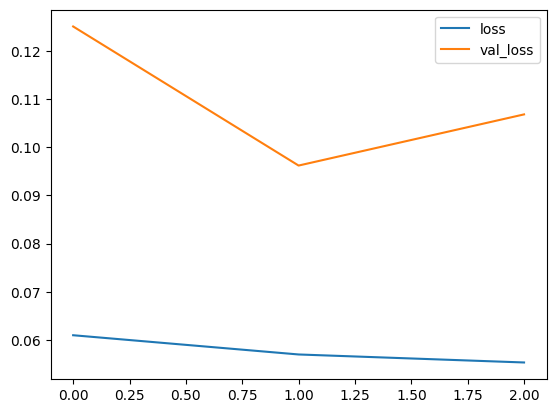

In [40]:
plt.plot(R.history['loss'], label='loss')
plt.plot(R.history['val_loss'], label='val_loss')
plt.legend()

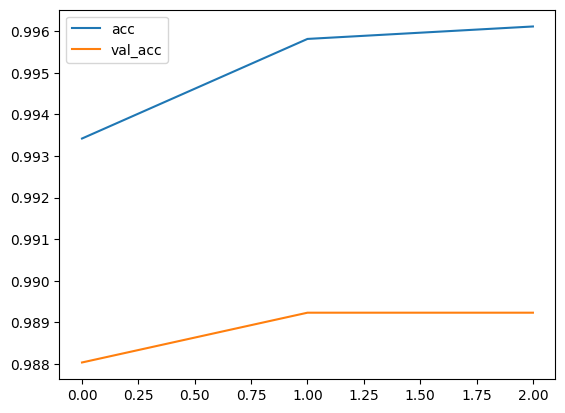

In [41]:
plt.plot(R.history['accuracy'], label='acc')
plt.plot(R.history['val_accuracy'], label='val_acc')
plt.legend()


In [42]:
def preprocessing(X):
  x = X.apply(lambda x: clean_txt(x))
  x = t.texts_to_sequences(x)
  return sequence.pad_sequences(x, maxlen=max_len)

In [44]:
s = model.evaluate(preprocessing(df_test['x']), Y_TEST)

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9877 - loss: 0.0826


In [45]:
print('Loss: {:.3f}, Accuracy: {:.3f}'.format(s[0], s[1]))

Loss: 0.086, Accuracy: 0.989


In [48]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  P=model.predict(preprocessing(pd.Series([pred_text])))[0]

  return (P[0], ("ham" if P<0.5 else "spam"))

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
(np.float32(0.0), 'ham')


In [49]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
You passed the challenge. Great job!
